本章将简单介绍二维数据的绘制, 即学习与工作中常见的"场"数据.
由于二维数据的绘制又通常以地理二维数据为主(即包含经纬度信息),
所以本章直接介绍绘制地理二维数据的绘制,而常规二维数据的绘制的代码跟地理二维数据的绘制代码没有本质区别,
不再详细介绍.

本章节以D(-1)JF与JJA的降水场和850 hPa风场的相关系数图为例展示如何绘制地理二维数据.
上述相关图其实展示了ENSO对此年夏季气候的影响.
(数据的时间依旧规定在1951-2020年)

In [1]:
# 导入必要的库
import numpy as np
import xarray as xr
import proplot as plot
from cartopy.util import add_cyclic_point # 避免图形中出现空白线
from scipy.stats import t # 用于计算临界相关系数

In [2]:
# 编写函数取出数据
def get_4seasons_data_5120(path, var, lat_range,
                           level=None):
    """
    path: 文件路径
    var: 变量名
    lat_range: 纬度范围(例如:np.arange(60, -62, -2))
    level: 抽取的层数(例如:850), 可能用于读取风场数据

    Return:
    lat: 纬度
    lon: 经度
    array_4seasons_5120: 变量的数组(year, seasons, lat, lon)
    """
    
    data = xr.open_dataset(path)
    if level is None:
        data = data.sel(lat=lat_range, time=slice('1950-01-01', '2020-12-31'))
    else:
        data = data.sel(lat=lat_range, level=level, time=slice('1950-01-01', '2020-12-31'))
    lat = data.lat.data
    lon = data.lon.data
    array = data[var].data
    
    array_4seasons_5120 = np.empty((70, 4, len(lat), len(lon)))
    for i in range(70):
        for season in range(4):
            index = 11 + 12*i + 3*season
            array_4seasons_5120[i, season] = array[index:index+3].mean(axis=0)

    # !!!扣除线性趋势(务必注意,除非是研究长期趋势的问题,否则都需要扣除长期线性趋势)
    for season in range(4):
        for i in range(len(lat)):
            for j in range(len(lon)):
                if (np.isnan(array_4seasons_5120[:, season, i, j].sum())):  # 排掉陆地值点
                    array_4seasons_5120[:, season, i, j] = np.nan
                else:
                    x = np.arange(1, 71, 1)
                    z = np.polyfit(x,array_4seasons_5120[:, season, i, j], 1) #用线性回归拟合出长期线性趋势
                    y = np.polyval(z, x)

                    array_4seasons_5120[:, season, i, j] = array_4seasons_5120[:, season, i, j] - y

    return lat, lon, array_4seasons_5120

def cal_area_index(array_yearly, lat, lon, lat_range, lon_range):
    """
    array_yearly: 需要求解区域均值变量的场数据(year, lat, lon)
    lat: array_yearly对应的纬度(1d array)
    lon: array_yearly对应的经度(1d array)
    lat_range: 纬度范围(list)
    lon_range: 经度范围(list)

    Return:
    area_index: 指数序列(1d array)

    Note: 此函数处理不了跨域lon=360的情况
    """

    # 得到纬度和经度的索引
    lat_min = min(lat_range)
    lat_max = max(lat_range)
    lat_index = (lat>=lat_min) & (lat<=lat_max)

    lon_min = min(lon_range)
    lon_max = max(lon_range)
    lon_index = (lon>=lon_min) & (lon<=lon_max)

    # 得到区域均值
    temp = array_yearly[:, lat_index]
    temp = temp[:, :, lon_index]
    area_index = np.nanmean(np.nanmean(temp, axis=-1), axis=-1)

    return area_index

In [3]:
# 获取数据
lat_sst, lon_sst, sst_4seasons_5120 = get_4seasons_data_5120(r'data/sst.mnmean_new.nc', 'sst',
                                                            np.arange(60, -62, -2) # 等价于slice(60, -60)
                                                            )
lat_wind, lon_wind, u850_4seasons_5120 = get_4seasons_data_5120(r'data/uwnd850.mon.mean.nc', 'uwnd',
                                                                np.arange(60, -62.5, -2.5))
lat_wind, lon_wind, v850_4seasons_5120 = get_4seasons_data_5120(r'data/vwnd850.mon.mean.nc', 'vwnd',
                                                                np.arange(60, -62.5, -2.5))
lat_precip, lon_precip, pre_4seasons_5120 = get_4seasons_data_5120(r'data/NOAA_Precipitation_Reconstruction.precip.mon.anom.nc', 'precip',
                                                                   slice(60, -60))

Nino34_DJF_5120 = cal_area_index(sst_4seasons_5120[:, 0],
                                 lat_sst, lon_sst, [-6, 6], [190, 240])

In [4]:
# 计算70年的临界相关系数(看不懂可以跳过)
n = 70
a = 0.1 # 0.1显著性水平
t_half_a = t.isf(a / 2, n - 2)
t_half_a = round(t_half_a, 5)
r_base = t_half_a / ((t_half_a ** 2) + n - 2) ** 0.5
r_base

0.19821036970041964

In [5]:
# 计算D(-1)JF的Nino34指数与JJA的降水场和850 hPa风场的相关系数场
u850_JJA_5120 = u850_4seasons_5120[:, 2]
v850_JJA_5120 = v850_4seasons_5120[:, 2]
pre_JJA_5120 = pre_4seasons_5120[:, 2]

# 求解相关系数场的函数
def get_corrmap(index, lat, lon, array_5120):
    """
    input:
    index: 指数序列(1d array)
    lat: array_5120对应的纬度(1d array)
    lon: array_5120对应的经度(1d array)
    array_5120: 场数据(year, lat, lon)

    Return:
    corrmap: 相关系数场(lat, lon)
    """

    corrmap = np.empty((len(lat), len(lon)))
    for i in range(len(lat)):
        for j in range(len(lon)):
            if (np.isnan(array_5120[:, i, j].sum())):  # 排掉陆地值点
                corrmap[i, j] = np.nan
            else:
                corr = np.corrcoef(index, array_5120[:, i, j])
                corrmap[i, j] = corr[0, 1]

    return corrmap

corrmap_pre = get_corrmap(Nino34_DJF_5120, lat_precip, lon_precip, pre_JJA_5120)
corrmap_u850 = get_corrmap(Nino34_DJF_5120, lat_wind, lon_wind, u850_JJA_5120)
corrmap_v850 = get_corrmap(Nino34_DJF_5120, lat_wind, lon_wind, v850_JJA_5120)



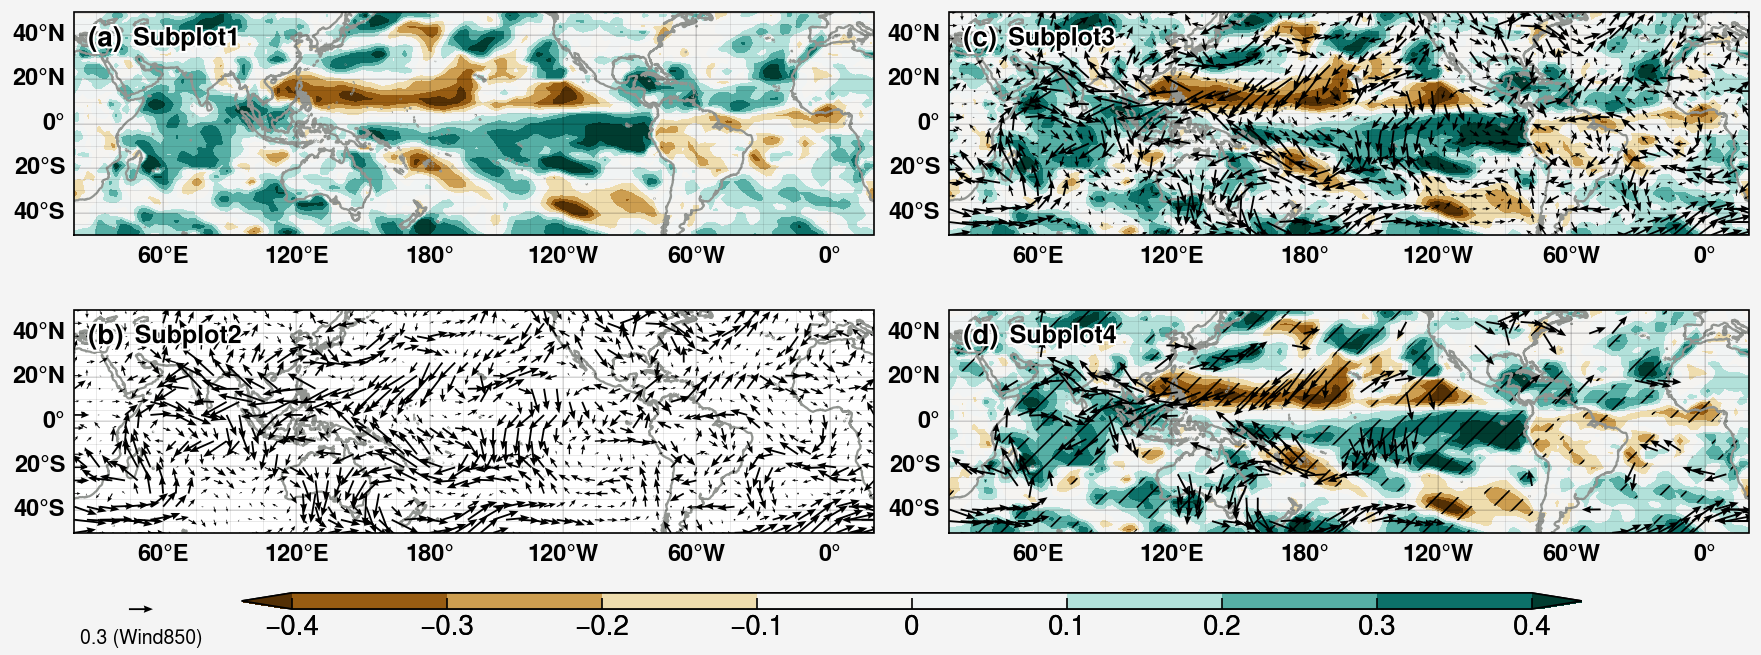

In [6]:
# 绘图
subplot_array = [[1, 3],
                 [2, 4]] # 子图的布局,1表示第一幅子图,2表示第二幅子图... (4幅子图代表了不同的二维数据图样式)
plot.rc.reso = 'med'  # 海岸线使用分辨率 'hi' 'med' 'lo'
proj = plot.Proj('cyl', lon_0=200)  # 投影可以指定,具体的可以参考proplot的文档(这里的lon_0表示中央经度)
fig = plot.figure(space=3,  # 图像间距
                  axwidth=4, )
axs = fig.subplots(subplot_array, proj=proj)
axs.format(
    abc='(a)', abcloc='ul', abcsize=10,
    gridlabelsize=8.5, # 坐标轴标签字体大小
    gridlabelweight='heavy', # 坐标轴标签字体粗细
    labels=True, # 是否显示坐标轴标签
    lonlines=60, # 经度标签间隔
    latlines=20, # 纬度标签间隔
    latlim=(-50.1, 50.1), # 图的纬度范围
    gridminor=True,  # 是否显示次级网格
    coast=True,   # 是否显示海岸线
    coastlinewidth=0.8, # 海岸线宽度
    coastcolor='gray', # 海岸线颜色
    coastzorder=0, # 海岸线图层(越小越先画)
    titlesize=9,  # 标题字体大小
    titleweight='heavy' # 标题字体粗细
)

cmap = plot.Colormap('BrBG') # 规定colormap

axs[0].format(ultitle='Subplot1') # 子图1的标题, upper left title
axs[1].format(ultitle='Subplot2') # 子图2的标题
axs[2].format(ultitle='Subplot3') # 子图3的标题
axs[3].format(ultitle='Subplot4') # 子图4的标题

# 绘制第一幅子图
# 绘制降水场的相关图
cycle_corrmapPre, cycle_lonPre = add_cyclic_point(corrmap_pre,
                                                  coord=lon_precip)  # 避免出现白线(本质问题是0°和360°经线是同一条)
m = axs[0].contourf(cycle_lonPre, lat_precip, cycle_corrmapPre,
                    cmap=cmap,
                    levels=np.arange(-0.4, 0.41, 0.1), # 等值线间隔
                    cmap_kw={'cut': -0.1}, # 将-0.1~0.1之间colormap颜色裁剪成白色
                    extend='both', # 扩展至两边(colorbar两头用箭头)
                    zorder=0
                    )

# 绘制第二幅子图
# 绘制风场的相关系数图
cycle_corrmapU850, cycle_lonWind850 = add_cyclic_point(corrmap_u850,
                                                    coord=lon_wind)
cycle_corrmapV850, _ = add_cyclic_point(corrmap_v850, coord=lon_wind)
q = axs[1].quiver(cycle_lonWind850, lat_wind,
                  cycle_corrmapU850, cycle_corrmapV850,
                  regrid_shape=18, # 重新网格化,即控制箭头疏密
                  minshaft=1.8,
                  headwidth=4,
                  scale=10, # 缩放
                  width=0.0023,
                  )

# 绘制第三幅子图
# 将降水场和风场的相关系数图叠加
m = axs[2].contourf(cycle_lonPre, lat_precip, cycle_corrmapPre,
                    cmap=cmap,
                    levels=np.arange(-0.4, 0.41, 0.1), # 等值线间隔
                    cmap_kw={'cut': -0.1}, # 将-0.1~0.1之间colormap颜色裁剪成白色
                    extend='both', # 扩展至两边(colorbar两头用箭头)
                    zorder=0, # 图层顺序(越小越先画,这里填色与海岸线是同一图层)
                    )
q = axs[2].quiver(cycle_lonWind850, lat_wind,
                  cycle_corrmapU850, cycle_corrmapV850,
                  regrid_shape=18, # 重新网格化,即控制箭头疏密
                  minshaft=1.8,
                  headwidth=4,
                  scale=10, # 缩放
                  width=0.0023,
                  zorder=1, # 箭头在填色图上面
                  )

# 绘制第四幅子图
# 在第三幅子图的基础上指明通过显著性检验的区域(填色图打上阴影, 风矢量仅保留通过显著性检验的)
m = axs[3].contourf(cycle_lonPre, lat_precip, cycle_corrmapPre,
                    cmap=cmap,
                    levels=np.arange(-0.4, 0.41, 0.1), # 等值线间隔
                    cmap_kw={'cut': -0.1}, # 将-0.1~0.1之间colormap颜色裁剪成白色
                    extend='both', # 扩展至两边(colorbar两头用箭头)
                    zorder=0, # 图层顺序(越小越先画,这里填色与海岸线是同一图层)
                    )
hatch = axs[3].contourf(cycle_lonPre, lat_precip, np.abs(cycle_corrmapPre),
                levels=[0, r_base, 1], cmap=cmap,
                hatches=[None, '///'], # 规定hatches来表示过检验的区域
                alpha=0, # 不要颜色(将透明度设置为全透明)
                zorder=0) # 其实也可以使用scatter完成打点, 因为hatches默认是黑色而且修改很烦

for i in range(len(lat_wind)):
    for j in range(len(cycle_lonWind850)):
        # 对于风场,只有u和v格点均不过检验时,才算不过检验
        if (np.abs(cycle_corrmapU850[i, j]) < r_base) and (np.abs(cycle_corrmapV850[i, j]) < r_base):
            cycle_corrmapU850[i, j] = np.nan
            cycle_corrmapV850[i, j] = np.nan
q = axs[3].quiver(cycle_lonWind850, lat_wind,
                  cycle_corrmapU850, cycle_corrmapV850,
                  regrid_shape=20, # 重新网格化,即控制箭头疏密
                  minshaft=1.8,
                  headwidth=4,
                  scale=10, # 缩放
                  width=0.0023,
                  zorder=1, # 箭头在填色图上面
                  )


# 最后把colorbar和风矢量图例加上
fig.colorbar(m, loc='b',
             width=0.08, # colorbar宽度
             length=0.8, # colorbar长度
             ticklabelsize=10, # colorbar刻度字体大小
             extendsize='2em', # 两边箭头的长度
             tickdir='in' # 刻度方向(in为内, out为外)
             )
axs[3].quiverkey(q,
                 X=0.08, # 图例横坐标位置
                 Y=0.07, # 图例纵坐标位置
                 U=0.3, # 图例中的代表大小
                 label='0.3 (Wind850)',
                 fontproperties={'size':7},
                 labelpos='S',
                 coordinates='figure')

# 保存图片(这里就先不运行了)
# fig.save(r'image/4_figure.png', # 保存图片的路径即文件名
#          dpi=600 # 保存图片的分辨率
#          )

## 小技巧

在很多文章中,我们可以发现其绘制的等值线都比较的平滑,而如果我们复现的话,
就会发现我们的图会出现比较多的锯齿,为了避免这种情况,我们可以先将需要绘制场进行平滑处理.
这里用的是高斯平滑

In [7]:
import scipy.ndimage as ndimage

cycle_corrmapPre, cycle_lonPre = add_cyclic_point(corrmap_pre,
                                                  coord=lon_precip)  # 避免出现白线(本质问题是0°和360°经线是同一条)

cycle_corrmapPre_smooth = ndimage.gaussian_filter(cycle_corrmapPre,
                                                  sigma=2, # 高斯函数的标准差,可以理解为平滑的程度
                                                  )



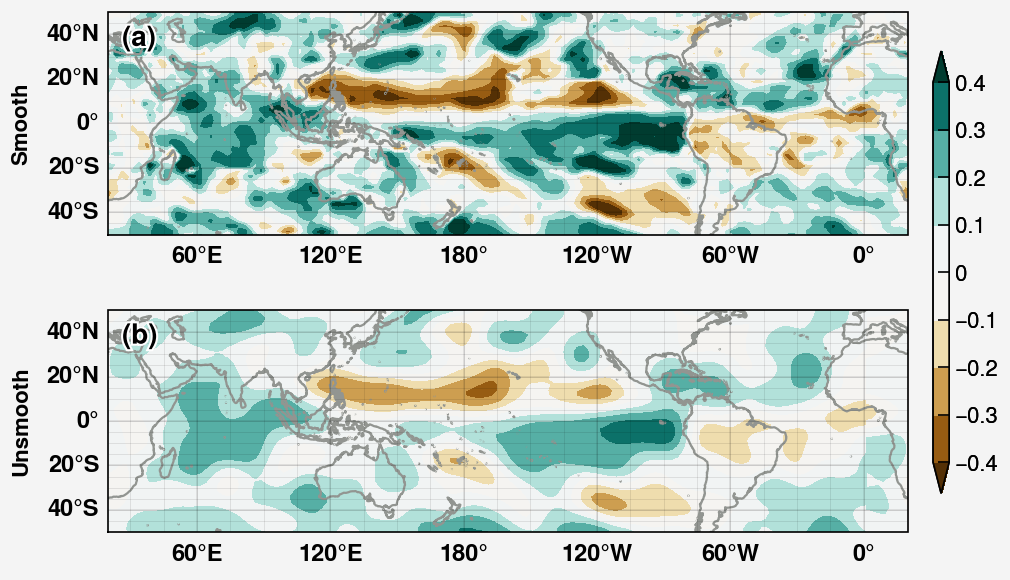

In [8]:
# 绘图
subplot_array = [[1],
                 [2]]

plot.rc.reso = 'med'  # 海岸线使用分辨率 'hi' 'med' 'lo'
proj = plot.Proj('cyl', lon_0=200)
fig = plot.figure(space=3,  # 图像间距
                  axwidth=4, )
axs = fig.subplots(subplot_array, proj=proj)
axs.format(
    abc='(a)', abcloc='ul', abcsize=10,
    gridlabelsize=8.5, # 坐标轴标签字体大小
    gridlabelweight='heavy', # 坐标轴标签字体粗细
    labels=True, # 是否显示坐标轴标签
    lonlines=60, # 经度标签间隔
    latlines=20, # 纬度标签间隔
    latlim=(-50.1, 50.1), # 图的纬度范围
    gridminor=True,  # 是否显示次级网格
    coast=True,   # 是否显示海岸线
    coastlinewidth=0.8, # 海岸线宽度
    coastcolor='gray', # 海岸线颜色
    coastzorder=0, # 海岸线图层(越小越先画)
    titlesize=9,  # 标题字体大小
    titleweight='heavy', # 标题字体粗细
    leftlabels=('Unsmooth', 'Smooth'), # 添加左边的行labels,具体效果看图
    leftlabelsize=8,
    # leftlabelrotation='horizontal' # 可以将左边的行labels水平放置
)

m = axs[0].contourf(cycle_lonPre, lat_precip, cycle_corrmapPre,
                    cmap=cmap,
                    levels=np.arange(-0.4, 0.41, 0.1), # 等值线间隔
                    cmap_kw={'cut': -0.1}, # 将-0.1~0.1之间colormap颜色裁剪成白色
                    extend='both', # 扩展至两边(colorbar两头用箭头)
                    zorder=0
                    )

m = axs[1].contourf(cycle_lonPre, lat_precip, cycle_corrmapPre_smooth,
                    cmap=cmap,
                    levels=np.arange(-0.4, 0.41, 0.1), # 等值线间隔
                    cmap_kw={'cut': -0.1}, # 将-0.1~0.1之间colormap颜色裁剪成白色
                    extend='both', # 扩展至两边(colorbar两头用箭头)
                    zorder=0
                    )

# 最后把colorbar和风矢量图例加上
fig.colorbar(m, loc='r', # 'r'即往右边放
             width=0.08, # colorbar宽度
             length=0.85, # colorbar长度
             ticklabelsize=8, # colorbar刻度字体大小
             extendsize='4em', # 两边箭头的长度
             tickdir='in' # 刻度方向(in为内, out为外)
             )

In [8]:
# 上面的等值线明显平滑了许多